In [ ]:
import warnings

import numpy as np
import os
import keras
from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import AveragePooling3D
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import Lambda
from keras.layers import GlobalAveragePooling3D,Flatten
from keras.models import Sequential
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# 그림 그리기
def plot_training_loss(H):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

In [ ]:
# 그림 그리기
def plot_training_acc(H):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training acc")
    plt.xlabel("Epoch #")
    plt.ylabel("acc")
    plt.legend(loc="lower left")

# Pre trained I3D

In [ ]:
WEIGHTS_NAME = ['rgb_kinetics_only', 'flow_kinetics_only', 'rgb_imagenet_and_kinetics', 'flow_imagenet_and_kinetics']

In [ ]:
# path to pretrained models with top (classification layer)
WEIGHTS_PATH = {
    'rgb_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels.h5',
    'flow_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels.h5',
    'rgb_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels.h5',
    'flow_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels.h5'
}

# path to pretrained models with no top (no classification layer)
WEIGHTS_PATH_NO_TOP = {
    'rgb_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels_no_top.h5',
    'flow_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels_no_top.h5',
    'rgb_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels_no_top.h5',
    'flow_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels_no_top.h5'
}


In [ ]:
def _obtain_input_shape(input_shape,
                        default_frame_size,
                        min_frame_size,
                        default_num_frames,
                        min_num_frames,
                        data_format,
                        require_flatten,
                        weights=None):

    if weights != 'kinetics_only' and weights != 'imagenet_and_kinetics' and input_shape and len(input_shape) == 4:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_num_frames, default_frame_size, default_frame_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_num_frames, default_frame_size, default_frame_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_num_frames, default_frame_size, default_frame_size)
        else:
            default_shape = (default_num_frames, default_frame_size, default_frame_size, 3)
    if (weights == 'kinetics_only' or weights == 'imagenet_and_kinetics') and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting`include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape

    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 4:
                    raise ValueError(
                        '`input_shape` must be a tuple of four integers.')
                if input_shape[0] != 3 and (weights == 'kinetics_only' or weights == 'imagenet_and_kinetics'):
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if input_shape[1] is not None and input_shape[1] < min_num_frames:
                    raise ValueError('Input number of frames must be at least ' +
                                     str(min_num_frames) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if ((input_shape[2] is not None and input_shape[2] < min_frame_size) or
                   (input_shape[3] is not None and input_shape[3] < min_frame_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_frame_size) + 'x' + str(min_frame_size) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 4:
                    raise ValueError(
                        '`input_shape` must be a tuple of four integers.')
                if input_shape[-1] != 3 and (weights == 'kinetics_only' or weights == 'imagenet_and_kinetics'):
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if input_shape[0] is not None and input_shape[0] < min_num_frames:
                    raise ValueError('Input number of frames must be at least ' +
                                     str(min_num_frames) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if ((input_shape[1] is not None and input_shape[1] < min_frame_size) or
                   (input_shape[2] is not None and input_shape[2] < min_frame_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_frame_size) + 'x' + str(min_frame_size) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None, None)
            else:
                input_shape = (None, None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape

In [ ]:
def conv3d_bn(x,
              filters,
              num_frames,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1, 1),
              use_bias = False,
              use_activation_fn = True,
              use_bn = True,
              name=None):

    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv3D(
        filters, (num_frames, num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=use_bias,
        name=conv_name)(x)

    if use_bn:
        if K.image_data_format() == 'channels_first':
            bn_axis = 1
        else:
            bn_axis = 4
        x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)

    if use_activation_fn:
        x = Activation('relu', name=name)(x)

    return x

In [ ]:
def Inception_Inflated3d(include_top=True,
                weights=None,
                input_tensor=None,
                input_shape=None,
                dropout_prob=0.0,
                endpoint_logit=True,
                classes=400):
    if not (weights in WEIGHTS_NAME or weights is None or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or %s' % 
                         str(WEIGHTS_NAME) + ' ' 
                         'or a valid path to a file containing `weights` values')

    if weights in WEIGHTS_NAME and include_top and classes != 400:
        raise ValueError('If using `weights` as one of these %s, with `include_top`'
                         ' as true, `classes` should be 400' % str(WEIGHTS_NAME))

    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_frame_size=224, 
        min_frame_size=80, 
        default_num_frames=32,
        min_num_frames=32,
        data_format=K.image_data_format(),
        require_flatten=include_top,
        weights=weights)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 4

    # Downsampling via convolution (spatial and temporal)
    x = conv3d_bn(img_input, 64, 7, 7, 7, strides=(2, 2, 2), padding='same', name='Conv3d_1a_7x7')

    # Downsampling (spatial only)
    x = MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='MaxPool2d_2a_3x3')(x)
    x = conv3d_bn(x, 64, 1, 1, 1, strides=(1, 1, 1), padding='same', name='Conv3d_2b_1x1')
    x = conv3d_bn(x, 192, 3, 3, 3, strides=(1, 1, 1), padding='same', name='Conv3d_2c_3x3')

    # Downsampling (spatial only)
    x = MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='MaxPool2d_3a_3x3')(x)

    # Mixed 3b
    branch_0 = conv3d_bn(x, 64, 1, 1, 1, padding='same', name='Conv3d_3b_0a_1x1')

    branch_1 = conv3d_bn(x, 96, 1, 1, 1, padding='same', name='Conv3d_3b_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 128, 3, 3, 3, padding='same', name='Conv3d_3b_1b_3x3')

    branch_2 = conv3d_bn(x, 16, 1, 1, 1, padding='same', name='Conv3d_3b_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 32, 3, 3, 3, padding='same', name='Conv3d_3b_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_3b_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 32, 1, 1, 1, padding='same', name='Conv3d_3b_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_3b')

    # Mixed 3c
    branch_0 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_3c_0a_1x1')

    branch_1 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_3c_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 192, 3, 3, 3, padding='same', name='Conv3d_3c_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_3c_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 96, 3, 3, 3, padding='same', name='Conv3d_3c_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_3c_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_3c_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_3c')


    # Downsampling (spatial and temporal)
    x = MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same', name='MaxPool2d_4a_3x3')(x)

    # Mixed 4b
    branch_0 = conv3d_bn(x, 192, 1, 1, 1, padding='same', name='Conv3d_4b_0a_1x1')

    branch_1 = conv3d_bn(x, 96, 1, 1, 1, padding='same', name='Conv3d_4b_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 208, 3, 3, 3, padding='same', name='Conv3d_4b_1b_3x3')

    branch_2 = conv3d_bn(x, 16, 1, 1, 1, padding='same', name='Conv3d_4b_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 48, 3, 3, 3, padding='same', name='Conv3d_4b_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4b_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4b_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4b')

    # Mixed 4c
    branch_0 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_4c_0a_1x1')

    branch_1 = conv3d_bn(x, 112, 1, 1, 1, padding='same', name='Conv3d_4c_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 224, 3, 3, 3, padding='same', name='Conv3d_4c_1b_3x3')

    branch_2 = conv3d_bn(x, 24, 1, 1, 1, padding='same', name='Conv3d_4c_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4c_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4c_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4c_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4c')

    # Mixed 4d
    branch_0 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_4d_0a_1x1')

    branch_1 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_4d_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 256, 3, 3, 3, padding='same', name='Conv3d_4d_1b_3x3')

    branch_2 = conv3d_bn(x, 24, 1, 1, 1, padding='same', name='Conv3d_4d_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4d_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4d_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4d_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4d')

    # Mixed 4e
    branch_0 = conv3d_bn(x, 112, 1, 1, 1, padding='same', name='Conv3d_4e_0a_1x1')

    branch_1 = conv3d_bn(x, 144, 1, 1, 1, padding='same', name='Conv3d_4e_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 288, 3, 3, 3, padding='same', name='Conv3d_4e_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_4e_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4e_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4e_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4e_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4e')

    # Mixed 4f
    branch_0 = conv3d_bn(x, 256, 1, 1, 1, padding='same', name='Conv3d_4f_0a_1x1')

    branch_1 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_4f_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 320, 3, 3, 3, padding='same', name='Conv3d_4f_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_4f_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_4f_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4f_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_4f_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4f')


    # Downsampling (spatial and temporal)
    x = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same', name='MaxPool2d_5a_2x2')(x)

    # Mixed 5b
    branch_0 = conv3d_bn(x, 256, 1, 1, 1, padding='same', name='Conv3d_5b_0a_1x1')

    branch_1 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_5b_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 320, 3, 3, 3, padding='same', name='Conv3d_5b_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_5b_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_5b_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_5b_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_5b_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_5b')

    # Mixed 5c
    branch_0 = conv3d_bn(x, 384, 1, 1, 1, padding='same', name='Conv3d_5c_0a_1x1')

    branch_1 = conv3d_bn(x, 192, 1, 1, 1, padding='same', name='Conv3d_5c_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 384, 3, 3, 3, padding='same', name='Conv3d_5c_1b_3x3')

    branch_2 = conv3d_bn(x, 48, 1, 1, 1, padding='same', name='Conv3d_5c_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_5c_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_5c_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_5c_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_5c')

    if include_top:
        # Classification block
        x = AveragePooling3D((2, 7, 7), strides=(1, 1, 1), padding='valid', name='global_avg_pool')(x)
        x = Dropout(dropout_prob)(x)

        x = conv3d_bn(x, classes, 1, 1, 1, padding='same', 
                use_bias=True, use_activation_fn=False, use_bn=False, name='Conv3d_6a_1x1')
 
        num_frames_remaining = int(x.shape[1])
        x = Reshape((num_frames_remaining, classes))(x)

        # logits (raw scores for each class)
        x = Lambda(lambda x: K.mean(x, axis=1, keepdims=False),
                   output_shape=lambda s: (s[0], s[2]))(x)

        if not endpoint_logit:
            x = Activation('softmax', name='prediction')(x)
    else:
        h = int(x.shape[2])
        w = int(x.shape[3])
        x = AveragePooling3D((2, h, w), strides=(1, 1, 1), padding='valid', name='global_avg_pool')(x)



    inputs = img_input
    # create model
    model = Model(inputs, x, name='i3d_inception')

    # load weights
    if weights in WEIGHTS_NAME:
        if weights == WEIGHTS_NAME[0]:   # rgb_kinetics_only
            if include_top:
                weights_url = WEIGHTS_PATH['rgb_kinetics_only']
                model_name = 'i3d_inception_rgb_kinetics_only.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['rgb_kinetics_only']
                model_name = 'i3d_inception_rgb_kinetics_only_no_top.h5'

        elif weights == WEIGHTS_NAME[1]: # flow_kinetics_only
            if include_top:
                weights_url = WEIGHTS_PATH['flow_kinetics_only']
                model_name = 'i3d_inception_flow_kinetics_only.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['flow_kinetics_only']
                model_name = 'i3d_inception_flow_kinetics_only_no_top.h5'

        elif weights == WEIGHTS_NAME[2]: # rgb_imagenet_and_kinetics
            if include_top:
                weights_url = WEIGHTS_PATH['rgb_imagenet_and_kinetics']
                model_name = 'i3d_inception_rgb_imagenet_and_kinetics.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['rgb_imagenet_and_kinetics']
                model_name = 'i3d_inception_rgb_imagenet_and_kinetics_no_top.h5'

        elif weights == WEIGHTS_NAME[3]: # flow_imagenet_and_kinetics
            if include_top:
                weights_url = WEIGHTS_PATH['flow_imagenet_and_kinetics']
                model_name = 'i3d_inception_flow_imagenet_and_kinetics.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['flow_imagenet_and_kinetics']
                model_name = 'i3d_inception_flow_imagenet_and_kinetics_no_top.h5'

        downloaded_weights_path = get_file(model_name, weights_url, cache_subdir='models')
        model.load_weights(downloaded_weights_path)

        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first' and K.backend() == 'tensorflow':
            warnings.warn('You are using the TensorFlow backend, yet you '
                          'are using the Theano '
                          'image data format convention '
                          '(`image_data_format="channels_first"`). '
                          'For best performance, set '
                          '`image_data_format="channels_last"` in '
                          'your keras config '
                          'at ~/.keras/keras.json.')

    elif weights is not None:
        model.load_weights(weights)

    return model

In [ ]:
model=Inception_Inflated3d(include_top=False,
                weights='rgb_imagenet_and_kinetics',
                input_tensor=None,
                input_shape=(32,224,224,3),
                dropout_prob=0.3,
                endpoint_logit=True,
                classes=6)

In [ ]:
model.summary()

In [ ]:
trasfer_model = Sequential()
trasfer_model.add(model)
trasfer_model.add(Flatten())
trasfer_model.add(Dropout(0.3))
trasfer_model.add(Dense(6,activation = 'softmax'))

In [ ]:
trasfer_model.summary()

In [ ]:
import numpy as np
saved_npz_train  = np.load('video_dataset_train.npz')
saved_npz_test  = np.load('video_dataset_test.npz')

In [ ]:
X_train=saved_npz_train['X']
y_train = saved_npz_train['Y']
X_test=saved_npz_test['X']
y_test = saved_npz_test['Y']

In [ ]:
saved_npz_train.close()
saved_npz_test.close()

In [ ]:
X_train=X_train.astype('float16')
X_train=X_train/255.0
X_test=X_test.astype('float16')
X_test=X_test/255.0

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.00001)
trasfer_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
history = trasfer_model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=30,
    validation_data=(X_test,y_test)
    )

Epoch 1/30
198/198 [==============================] - 69s 336ms/step - loss: 1.3918 - accuracy: 0.5218 - val_loss: 1.4112 - val_accuracy: 0.5328
Epoch 2/30
198/198 [==============================] - 47s 235ms/step - loss: 1.3816 - accuracy: 0.5142 - val_loss: 1.4040 - val_accuracy: 0.5328
Epoch 3/30
198/198 [==============================] - 46s 232ms/step - loss: 1.3803 - accuracy: 0.5009 - val_loss: 1.3982 - val_accuracy: 0.5354
Epoch 4/30
198/198 [==============================] - 46s 233ms/step - loss: 1.3719 - accuracy: 0.5294 - val_loss: 1.3915 - val_accuracy: 0.5354
Epoch 5/30
198/198 [==============================] - 46s 234ms/step - loss: 1.3683 - accuracy: 0.5174 - val_loss: 1.3858 - val_accuracy: 0.5379
Epoch 6/30
198/198 [==============================] - 46s 234ms/step - loss: 1.3539 - accuracy: 0.5294 - val_loss: 1.3797 - val_accuracy: 0.5379
Epoch 7/30
198/198 [==============================] - 46s 235ms/step - loss: 1.3476 - accuracy: 0.5287 - val_loss: 1.3741 - val_ac

In [ ]:
trasfer_model.save('tran_video_model.h5')

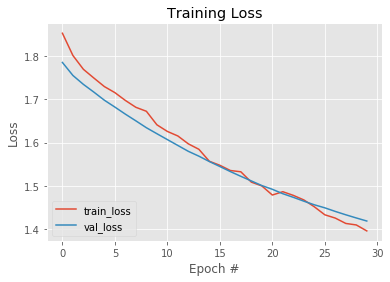

In [ ]:
plot_training_loss(history)

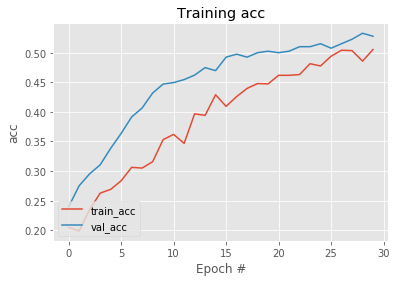

In [ ]:
plot_training_acc(history)